In [62]:
#All Libraries used
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [63]:
#Import Dataset
df = pd.read_csv('loan_default_prediction.csv')
print(df.shape)

(87500, 30)


In [64]:
#drop
vdrop=['ID','Validation','Designation','Debt_to_Income','Postal_Code','Deprecatory_Records',\
            'Inquiries','Gross_Collection','Sub_GGGrade','Total_Unpaid_CL','File_Status','Claim_Type']
df=df.drop(vdrop,axis=1)
df.shape

(87500, 18)

In [65]:
def romanToInt(i):
    roman = {'I':1,'V':5,'X':10,'L':50,'C':100,'D':500,'M':1000,'IV':4,'IX':9,'XL':40,'XC':90,'CD':400,'CM':900}
    j = 0
    num = 0
    while j < len(i):
        if j+1<len(i) and i[j:j+2] in roman:
            num+=roman[i[j:j+2]]
            j+=2
        else:

            num+=roman[i[j]]
            j+=1
    return num

In [66]:
#Conversão dos anos de experiência para numérico
df['Experience']=df['Experience'].apply(lambda i: 10 if i[0:1]=='>' else 1 if i[0:1]=='<' else int(i[0:1]))
#Conversão da duração para numérico
df['Duration']=df['Duration'].apply(lambda i : i.replace(' years','')).astype(int)
#Conversão da GGGrade valor ordinal para numérico
df['GGGrade']=df['GGGrade'].apply(romanToInt).astype(int)
#ver resultado
#df.head()

In [67]:
#eliminar observações com pelo menos uma feature sem valores
df=df.dropna()
#drop duplicates
df.drop_duplicates()
df.shape

(77376, 18)

In [68]:
#df.describe()
df.head(5)

,Asst_Reg,GGGrade,Experience,Yearly_Income,Home_Status,Unpaid_2_years,Already_Defaulted,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,State,Account_Open,Duration,Unpaid_Amount,Reason,Due_Fee,Default
0,421802,2,10,633600.00,MORTGAGE,0,0,42023.25,15.39,88.924,607161.90,California,17,3,31216.05,debt consolidation,0.0,0
1,3964312,4,7,85483.20,RENT,0,0,38133.00,9.94,102.856,269234.06,NC,15,5,11660.49,debt consolidation,0.0,0
2,4247560,3,1,79200.00,RENT,0,0,17100.00,22.35,60.372,22476.53,Florida,7,5,5637.87,major purchase,0.0,0
3,197179,3,1,61600.00,RENT,0,0,5130.00,10.36,116.272,15242.09,NewJersey,9,3,15607.17,major purchase,0.0,1
4,4646684,5,2,68053.92,RENT,0,0,19665.00,13.68,127.280,65433.94,LA,10,5,27472.86,debt consolidation,0.0,0


In [69]:
#Divisão do dataset
v_num_cont=['Asst_Reg','Experience','Yearly_Income','Lend_Amount','Interest_Charged','Usage_Rate',
            'Present_Balance','Due_Fee','Unpaid_Amount']
v_num_disc=['Unpaid_2_years','Already_Defaulted','Account_Open','Duration']
v_cat_ord=['Home_Status','State','Reason','GGGrade']

In [71]:
#Ver qual as variáveis ordinais mais dominantes
for i in v_cat_ord:
    print(df[i].value_counts())


MORTGAGE    39077
RENT        30853
OWN          7436
OTHER           6
NONE            4
Name: Home_Status, dtype: int64
California    11194
Newyork        6414
TX             6307
Florida        5149
IL             3091
NewJersey      2877
PA             2797
Ohio           2602
GA             2572
VA             2251
NC             2230
MI             1995
Maryland       1857
AZ             1797
MA             1764
CO             1685
WA             1627
MN             1493
IN             1276
MO             1253
TN             1184
CT             1172
NV             1039
AL              999
WI              990
OR              929
LA              908
SC              888
KY              728
KS              722
OK              676
AR              564
UT              556
NM              424
HI              423
MS              370
NH              365
WV              344
RI              337
MT              225
DC              206
DE              205
AK              198
WY              16

In [72]:
#Remover outliers
from scipy import stats
display(df.shape)
#Remove "other" and "none"
df=df[(df['Home_Status']!='OTHER')&(df['Home_Status']!='NONE')]
#Tirar a médias e divide pelo desvio padrão
df=df[(np.abs(stats.zscore(df[v_num_cont])) < 3).all(axis=1)]
display(df.shape)

(77376, 18)

(74132, 18)

In [73]:
#Número de default positivos
(df['Default']==1).sum()

14126

In [75]:
#Undersapling
defaulted = df[df['Default']==1].sample(n=5000, random_state=101)
notdefault = df[df['Default']==0].sample(n=5000, random_state=101)
df = pd.concat([defaulted,notdefault],axis=0)
df.shape
df = df.reset_index()
display(df.index)
#aplicar undersampling com sklearn

RangeIndex(start=0, stop=10000, step=1)

# Train vs test sample: standard and cross-validation

In [81]:
# Split the data into features (X) and labels (y)
X = df[v_num_cont]
y = df['Default']

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#implement cross validation
from sklearn.model_selection import KFold

X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14], [15, 16], [17, 18], [19, 20]])
y = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

kfold = KFold(n_splits=10,shuffle=True)

for train_index, test_index in kfold.split(X):
    print("Train index:", train_index, "Test index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Train index: [0 1 2 3 4 5 6 8 9] Test index: [7]
Train index: [0 1 2 3 4 5 7 8 9] Test index: [6]
Train index: [0 2 3 4 5 6 7 8 9] Test index: [1]
Train index: [0 1 2 3 4 5 6 7 9] Test index: [8]
Train index: [0 1 3 4 5 6 7 8 9] Test index: [2]
Train index: [1 2 3 4 5 6 7 8 9] Test index: [0]
Train index: [0 1 2 3 4 6 7 8 9] Test index: [5]
Train index: [0 1 2 4 5 6 7 8 9] Test index: [3]
Train index: [0 1 2 3 5 6 7 8 9] Test index: [4]
Train index: [0 1 2 3 4 5 6 7 8] Test index: [9]


# Pipelines

In [82]:
#make the input data as "normal" as possible
#start by decreasing the skewness and assessing which are asymmetric
def skew_df(df):
    from scipy.stats import skewtest
    skewness, p_value = skewtest(df)
    dskew=pd.DataFrame(np.round(np.vstack((skewness.T,p_value.T)),2),columns=df.columns,
                    index=['skewness', 'p_value'])
    return(dskew)

#aplica esta métricas às variáveis continuas

dskew=skew_df(df[v_num_cont])
display(dskew)

#Treshoold 0.5
dskew.columns[dskew.loc['p_value']<0.05]
#quando mais o p_value for próximo de 0 mais assimétrico é
Transformação para as transforma

,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Interest_Charged,Usage_Rate,Present_Balance,Due_Fee,Unpaid_Amount
skewness,15.38,-7.9,42.65,25.65,-0.48,-7.74,38.59,1.00,49.36
p_value,0.00,0.0,0.00,0.00,0.63,0.00,0.00,0.32,0.00


Index(['Asst_Reg', 'Experience', 'Yearly_Income', 'Lend_Amount', 'Usage_Rate',
       'Present_Balance', 'Unpaid_Amount'],
      dtype='object')

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

# Define the transformations to apply to the column
transformer = ColumnTransformer([
    #('scale', PowerTransformer(), ['col1']),  # Scale the numeric column
    ('yeoj', PowerTransformer(), dskew.columns[dskew.loc['p_value']<0.05])  # One-hot encode the column
])

# Transform the data
df_transformed = transformer.fit_transform(X_train)
#display(X_train)
X_train_transformed= pd.concat([pd.DataFrame(df_transformed,
                                  columns=dskew.columns[dskew.loc['p_value']<0.05],index=X_train.index),
                               X_train[dskew.columns[dskew.loc['p_value']>=0.05]]],
                               axis=1)
#display(X_train[dskew.columns[dskew.loc['p_value']>=0.05]])
X_train_transformed

,Asst_Reg,Experience,Yearly_Income,Lend_Amount,Usage_Rate,Present_Balance,Unpaid_Amount,Interest_Charged,Due_Fee
9254,1.333455,1.084212,0.734597,1.185273,0.487517,0.553462,1.792878,19.39,0.0
1561,-1.173896,0.050424,-0.320546,-1.311223,-0.492565,-1.191977,-1.060496,24.24,0.0
1670,-1.143481,-0.519924,-0.903321,-0.558293,-0.501115,-0.536214,-0.207936,21.72,0.0
6087,1.146308,1.084212,-0.360919,0.662361,-1.578597,-0.774602,-0.064845,20.43,0.0
6669,1.406309,1.084212,-1.836748,-1.283128,-1.385828,-1.138176,-1.674696,20.85,0.0
...,...,...,...,...,...,...,...,...,...
5734,1.149179,0.320072,1.054637,1.274243,-1.333479,1.098302,0.877176,22.38,0.0
5191,0.968053,-0.228886,-0.529100,-0.402970,-1.866332,-0.833991,-1.824126,18.97,0.0
5390,1.204036,-0.825722,-0.054328,-0.186242,-0.969226,-1.279444,-0.312175,9.53,0.0
860,0.657779,-1.151117,-1.533211,-0.402970,0.115725,-0.727794,0.347738,8.15,0.0


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the logistic regression model
model = LogisticRegression()
# Define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.2f}")

# Make predictions on new data
y_pred = grid_search.predict(X_test)

Best parameters: {'C': 0.001}
Best score: 0.73


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73       988
           1       0.74      0.71      0.73      1012

    accuracy                           0.73      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.73      0.73      0.73      2000



In [38]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
#print(accuracy_score(y_test,y_pred))
#print(precision_score(y_test,y_pred))
#print(recall_score(y_test,y_pred))
#print(f1_score(y_test,y_pred))

In [39]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Compute the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

# Compute the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(roc_auc)

# Generate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

[[739 249]
 [290 722]]
0.7307072218399449


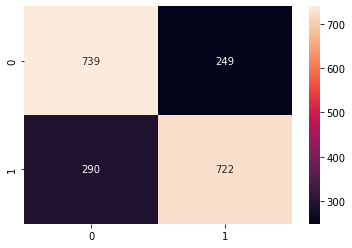

In [40]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='g');

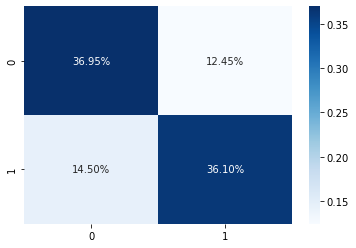

In [41]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues');

In [42]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

0.7305
0.7435633367662204
0.7134387351778656
0.7281896116994453


In [43]:
# Create a copy of the data
X_transformed = df[v_num_cont].copy()

# Logarithmize variables with skewness greater than a threshold
for i in range(0,len(X_transformed.columns)):
    if (dskew.loc['p_value'])[i] < 0.05:
        print(i)
    #   X_transformed.iloc[:, i] = (X_transformed.iloc[:, i]).apply(np.log)

#log_skewed(df[v_num_cont],dskew,0.05)

0
1
2
3
5
6
8


In [45]:
from scipy.stats import yeojohnson
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

yeojohnson(X_transformed.iloc[:, 1])

pt = PowerTransformer()

pipe=Pipeline([
    #('yeoj',PowerTransformer()),
    ('ratio', FunctionTransformer(yeojohnson, validate=False, kw_args={'columns': [0, 1]}))
    #('zscore',StandardScaler())
])

In [46]:
pipe.fit_transform(X_train)

TypeError: yeojohnson() got an unexpected keyword argument 'columns'

In [47]:
# Compute the skewness of the feature variables
skewness = skew(X)

# Create a function to logarithmize variables with statistically significant skewness
def logarithmize_skewed_variables(X):
    # Create a copy of the data
    X_transformed = X.copy()

    # Logarithmize variables with skewness greater than a threshold
    threshold = 1.0
    for i, s in enumerate(skewness):
        if np.abs(s) > threshold:
            X_transformed[:, i] = np.log1p(X_transformed[:, i])

    return X_transformed

# Create a function transformer to logarithmize variables with statistically significant skewness
logarithmize_transformer = FunctionTransformer(logarithmize_skewed_variables, validate=True)

# Create a feature selector to select the top k features
k = 10
feature_selector = SelectKBest(k=k)

# Create a pipeline
pipeline = Pipeline([
    ('logarithmize', logarithmize_transformer),
    ('select_features', feature_selector)
])

NameError: name 'skew' is not defined

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
# Create a function that returns the ratio of the specified columns
def get_ratio(x, columns):
    return x[:, columns[0]] / x[:, columns[1]]
# Create a function that returns the log of the input if it is positive, or the input itself otherwise
def log_positive(x):
    return np.log(x) if x > 0 else x
# Create a pipeline that first logarithmizes the specified columns, then standardizes the data
pipeline = Pipeline([
    ('ratio', FunctionTransformer(get_ratio, validate=False, kw_args={'columns': [0, 1]})),
    ('log', FunctionTransformer(log_positive, validate=False, kw_args={'columns': [0, 1]}))
]),
    ('standardize', StandardScaler())
])

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]

# Apply the pipeline to the data
X_transformed = pipeline.fit_transform(X)

# Print the transformed data
print(X_transformed)

#This code will create a pipeline that first applies the log_positive function to the specified columns, and then standardizes the data using the StandardScaler class. It will then apply the pipeline to the data X and print the transformed data to the console.

#You can use a different set of transformations in place of logarithmization and standardization, as needed. You can also specify the columns to be transformed by passing the columns parameter to the FunctionTransformer constructor, or you can use a different transformer class to apply a different set of transformations.


IndentationError: unexpected indent (2038413857.py, line 14)

# Feature selection

In [49]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [0, 1, 0, 1, 0]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
model = RandomForestClassifier()

# Use Recursive Feature Elimination (RFE) to select the top 2 features
rfe = RFE(model, 2)
rfe.fit(X_train, y_train)

# Transform the training and test data using the selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Train the model on the selected features
model.fit(X_train_selected, y_train)

# Make predictions on the selected features of the test data
predictions = model.predict(X_test_selected)

# Print the accuracy
print(accuracy_score(y_test, predictions))

############################################################
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [0, 1, 0, 1, 0]

# Create a list of all the feature indices
feature_indices = list(range(X.shape[1]))

# Set the initial set of features to be an empty list
selected_features = []

# Set the maximum number of features to select
max_features = 2

# Initialize the best cross-validated score to be negative infinity
best_score = -np.inf

# Iterate over all possible combinations of features
for i in range(1, len(feature_indices) + 1):
    for combination in combinations(feature_indices, i):
        # Select the current combination of features
        X_selected = X[:, combination]
        
        # Train a logistic regression model with 5-fold cross-validation
        model = LogisticRegression()
        score = cross_val_score(model, X_selected, y, cv=5).mean()
        
        # If the current combination of features has a higher cross-validated score than the best score, update the best score and the selected features
        if score > best_score:
            best_score = score
            selected_features = combination

# Print the selected features
print(selected_features)
##########################################
#BACKWARD

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [0, 1, 0, 1, 0]

# Create a list of all the feature indices
feature_indices = list(range(X.shape[1]))

# Set the initial set of features to be all the features
selected_features = feature_indices

# Set the minimum number of features to select
min_features = 1

# Initialize the best cross-validated score to be negative infinity
best_score = -np.inf

# Iterate over all possible combinations of features
while len(selected_features) > min_features:
    scores = []
    for i in range(len(selected_features)):
        # Select the current combination of features
        X_selected = X[:, selected_features]
        
        # Train a logistic regression model with 5-fold cross-validation
        model = LogisticRegression()
        score = cross_val_score(model, X_selected, y, cv=5).mean()
        
        # Add the score for the current combination of features
        scores.append(score)
    
    # Find the index of the feature with the lowest score
    worst_feature_index = np.argmin(scores)
    
    # If the current combination of features has a higher cross-validated score than the best score, update the best score and the selected features
    if scores[worst_feature_index] > best_score:
        best_score = scores[worst_feature_index]
        selected_features = selected_features[:worst_feature_index] + selected_features[worst_feature_index + 1:]
    else:
        # If the current combination of features has a lower cross-validated score than the best score, stop the search
        break

# Print the selected features
print(selected_features)

TypeError: __init__() takes 2 positional arguments but 3 were given

In [51]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [52]:
# Fit different models and evaluate their performance
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    MLPClassifier()
]

for model in models:
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    print(f"{model.__class__.__name__}: {accuracy:.2f}")

LogisticRegression: 0.00
DecisionTreeClassifier: 0.00
RandomForestClassifier: 0.00
SVC: 0.00
MLPClassifier: 0.00


C:\Users\familia feliz\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [53]:
#STACKING
# Define the base models
base_models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    MLPClassifier()
]

# Define the second-level model
meta_model = LogisticRegression()

# Define the stacking model
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Fit the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = stacking_model.predict(X_test)

# Evaluate the model
accuracy = stacking_model.score(X_test, y_test)
print("Accuracy:", accuracy)


NameError: name 'StackingClassifier' is not defined

In [54]:
from sklearn.decomposition import PCA
  
pca = PCA(n_components = 2)
  
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
  
explained_variance = pca.explained_variance_ratio_

SyntaxError: invalid non-printable character U+00A0 (3957181239.py, line 2)

In [55]:
import numpy as np



In [56]:
#xgboost
from xgboost import XGBClassifier

# Create the XGBoost model
model = XGBClassifier()

# Train the model
model.fit(X_train, y_train)

ModuleNotFoundError: No module named 'xgboost'

In [57]:
#CLUSTERING AS PREPROCESSING DATA INTO CLASSIFICATION PROBLEM
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [0, 1, 0, 1, 0]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use KMeans to cluster the training data into 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train)

# Add the cluster labels as a new feature in the training data
X_train_clustered = np.concatenate((X_train, kmeans.labels_.reshape(-1, 1)), axis=1)

# Create a Random Forest classifier and train it on the clustered data
model = RandomForestClassifier()
model.fit(X_train_clustered, y_train)

# Add the cluster labels as a new feature in the test data
X_test_clustered = np.concatenate((X_test, kmeans.predict(X_test).reshape(-1, 1)), axis=1)

# Make predictions on the test data
predictions = model.predict(X_test_clustered)

One way to pick the optimal number of clusters for a clustering algorithm is to use an evaluation metric that compares the quality of different clusterings. There are many such metrics available, such as the silhouette score, the Calinski-Harabasz index, and the Davies-Bouldin index.

In [58]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]

# Try clustering the data with different numbers of clusters
for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    cluster_labels = kmeans.predict(X)

    # Calculate the silhouette score for this number of clusters
    score = silhouette_score(X, cluster_labels)
    print("Number of clusters:", n_clusters, "Silhouette score:", score)
    
    ###################
#PROF DOC

from sklearn.pipeline import Pipeline
pipeline = Pipeline([
("kmeans", KMeans(n_clusters=50)),
("log_reg", LogisticRegression()),
])
pipeline.fit(X_train, y_train)

from sklearn.model_selection import GridSearchCV
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)
Let’s look at the best value for k and the performance of the resulting pipeline:
>>> grid_clf.best_params_
{'kmeans__n_clusters': 99}
>>> grid_clf.score(X_test, y_test)
0.9822222222222222

SyntaxError: invalid character '’' (U+2019) (2572941075.py, line 31)

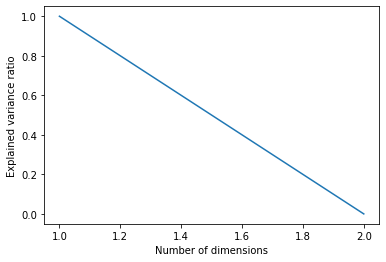

In [59]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the data
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]

# Create a PCA object and fit it to the data
pca = PCA()
pca.fit(X)

# Plot the explained variance ratio as a function of the number of dimensions
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Number of dimensions')
plt.ylabel('Explained variance ratio')
plt.show()

In [60]:
# Choose the optimal number of dimensions based on the explained variance ratio
n_dimensions = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1

# Transform the training and test data using the chosen number of dimensions
X_train_transformed = pca.transform(X_train)[:, :n_dimensions]
X_test_transformed = pca.transform(X_test)[:, :n_dimensions]

There are many different types of clustering algorithms, but some of the most common ones include:

    K-means clustering: This is a centroid-based algorithm that divides a dataset into a predefined number of clusters by minimizing the sum of squared distances between the points and the cluster centroids.

    Hierarchical clustering: This is an agglomerative algorithm that builds a hierarchy of clusters by iteratively merging the closest pairs of clusters.

    DBSCAN: This is a density-based algorithm that divides a dataset into clusters based on the density of the points. It is able to identify clusters of different shapes and sizes and can handle noisy or outlier points.

    Expectation-maximization (EM): This is a probabilistic algorithm that estimates the underlying distribution of the data and uses it to identify clusters.

    Affinity propagation: This is a message-passing algorithm that identifies clusters by exchanging messages between pairs of points until a consensus is reached.